# Gene Regulation in Immune Cells - ab and gd T Cells

## 0. Import of Packages and Data Preparation
---

In [2]:
# --- Grundlegende Pakete ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Farben und Visualisierung ---
from matplotlib.colors import ListedColormap, LogNorm
import matplotlib.patches as mpatches

# --- Statistik und Metriken ---
import scipy.stats
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity

# --- Clustering & Dim-Red ---
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn.manifold as sklm
import umap

# --- Single-cell Analysis ---
import scanpy as sc
#import leidenalg

# --- Sonstiges ---
import importlib

import functions
importlib.reload(functions)
functions.set_user('Kaja')

d:\Uni\4. Semester\Bioinfo\abT-gdT-cells-Team3\abT-gdT-cells-Team3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data = functions.call_data_clean(p_threshold=None)
ATAC = data['ATAC_seq']
RNA = data['RNA_seq']
QC = data['QC_metrics']
ATAC_scores = data['norm_scores']
exons = data['exons']
ATACtest = data['test1']
# ATAC_dis_path = '/Users/piakentschke/Documents/Uni/Data Analysis/ATAC_dis_annotated.csv'
# path Kaja:
ATAC_dis = pd.read_csv("D:\\Uni\\4. Semester\\Bioinfo\\datasets\\ATAC_dis_annotated.csv")
#ATAC_dis = pd.read_csv("ATAC_dis_annotated.csv", header=0, index_col=0)
ATAC_T = data['ATAC_seq_T']
list_ATAC_scores = data['list_ATAC_scores']
ATAC_top = data['top2500std']

Clean-up performed in functions.py (only 5 peaks with infinite log_p_values were excluded and a p-threshold of 1.3 can be applied)

##### RNA dataset

In [5]:
print(f'Number of NAs in RNA:{RNA.isna().sum().sum()}')
print(f'Number of entries <1 in RNA:{(RNA.iloc[:, 1:] < 1).sum().sum()}')
numerical_data=RNA.iloc[:, 1:]

sample_sums=numerical_data.sum(axis=0)
low_sum_samples=sample_sums[sample_sums <= 100]
print(f'Number of columns with overall sum <100: {len(low_sum_samples)}')
sample_variance=numerical_data.var(axis=0)
low_variance_samples=sample_variance[sample_variance <= 0.5]
print(f'Number of columns with overall var <0.5: {len(low_variance_samples)}')

same_cols = set(ATAC_scores.columns) & set(RNA.columns)
print("Cell types in both RNA and ATAC:", len(same_cols))
print("Cell types only in ATAC:", set(ATAC_scores.columns) - set(RNA.columns))
print("Cell types only in RNA:", set(RNA.columns) - set(ATAC_scores.columns))

Number of NAs in RNA:0
Number of entries <1 in RNA:0
Number of columns with overall sum <100: 0
Number of columns with overall var <0.5: 0
Cell types in both RNA and ATAC: 85
Cell types only in ATAC: {'DC.103+11b+.SI', 'preB.FrD.BM', 'MF.LP.SI', 'DC.103+11b-.SI', 'T8.IEL.LCMV.d7.SI'}
Cell types only in RNA: {'T8.IEL.LCMV.d7.Gut'}


## 1. Characterization of the Chromatin Landscape
---

#### 1.1 How variable is the chromatin signal within and across cells?

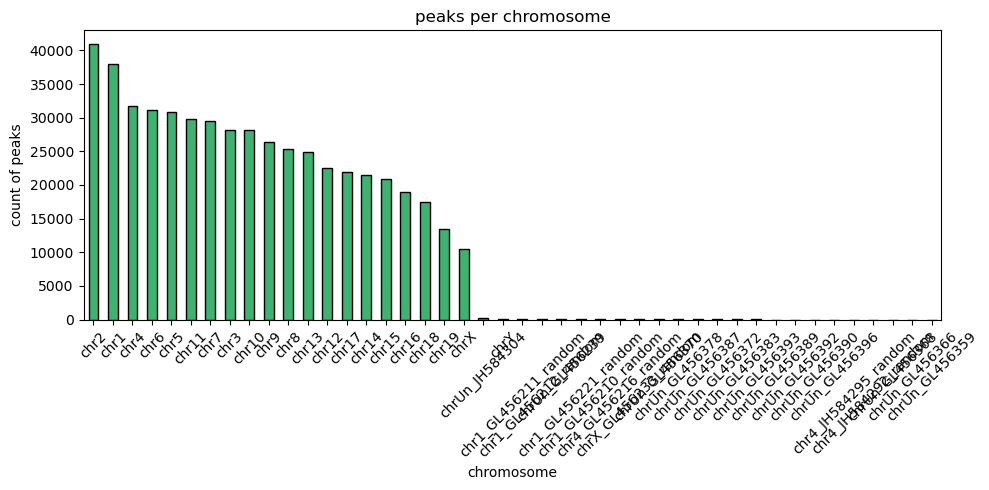

In [13]:
# counts of ATAC peaks per chromosome
chrom_counts = ATAC["chrom"].value_counts().sort_values(ascending=False)
peak_list = list(zip(chrom_counts.index, chrom_counts.values))

plt.figure(figsize=(10,5))
chrom_counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title("peaks per chromosome")
plt.xlabel("chromosome")
plt.ylabel("count of peaks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_6648\626209528.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=variability_filtered.index, y=variability_filtered.values, palette="viridis")


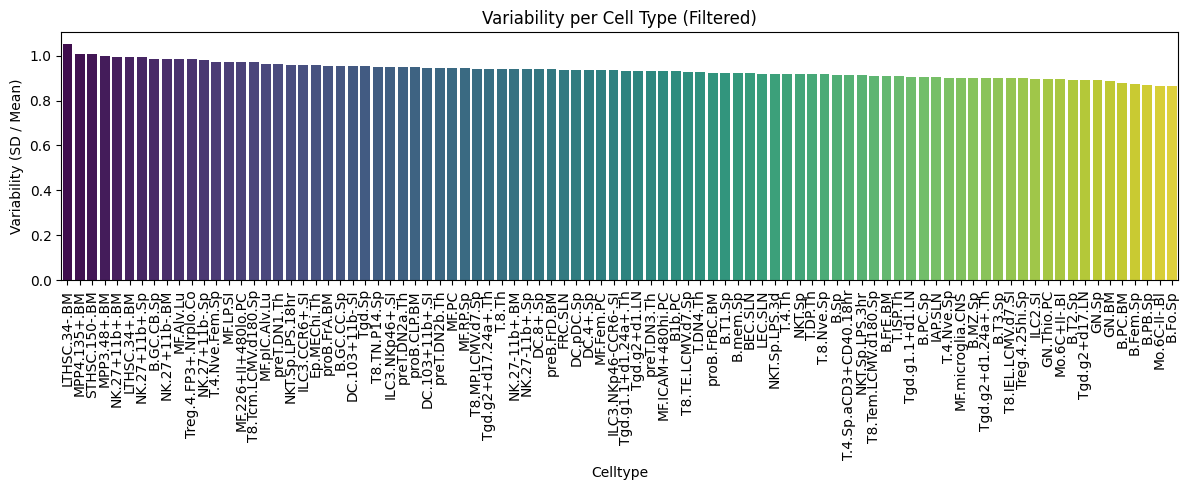

In [9]:
atac_data=ATAC.copy()

    
atac_data=atac_data.select_dtypes(include='number')
atac_data=atac_data.T

mean_per_celltype=atac_data.mean(axis=1)
std_per_celltype=atac_data.std(axis=1)

variability=std_per_celltype/(mean_per_celltype+1e-6)

variability_sorted = variability.sort_values(ascending=False)

exclude = ['Summit', 'Included.in.systematic.analysis', '_-log10_bestPvalue', 'mm10.60way.phastCons_scores']

variability_filtered = variability_sorted[~variability_sorted.index.isin(exclude)]

# Barplot
plt.figure(figsize=(12, 5))
sns.barplot(x=variability_filtered.index, y=variability_filtered.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Variability (SD / Mean)")
plt.xlabel("Celltype")
plt.title("Variability per Cell Type (Filtered)")
plt.tight_layout()
plt.show()

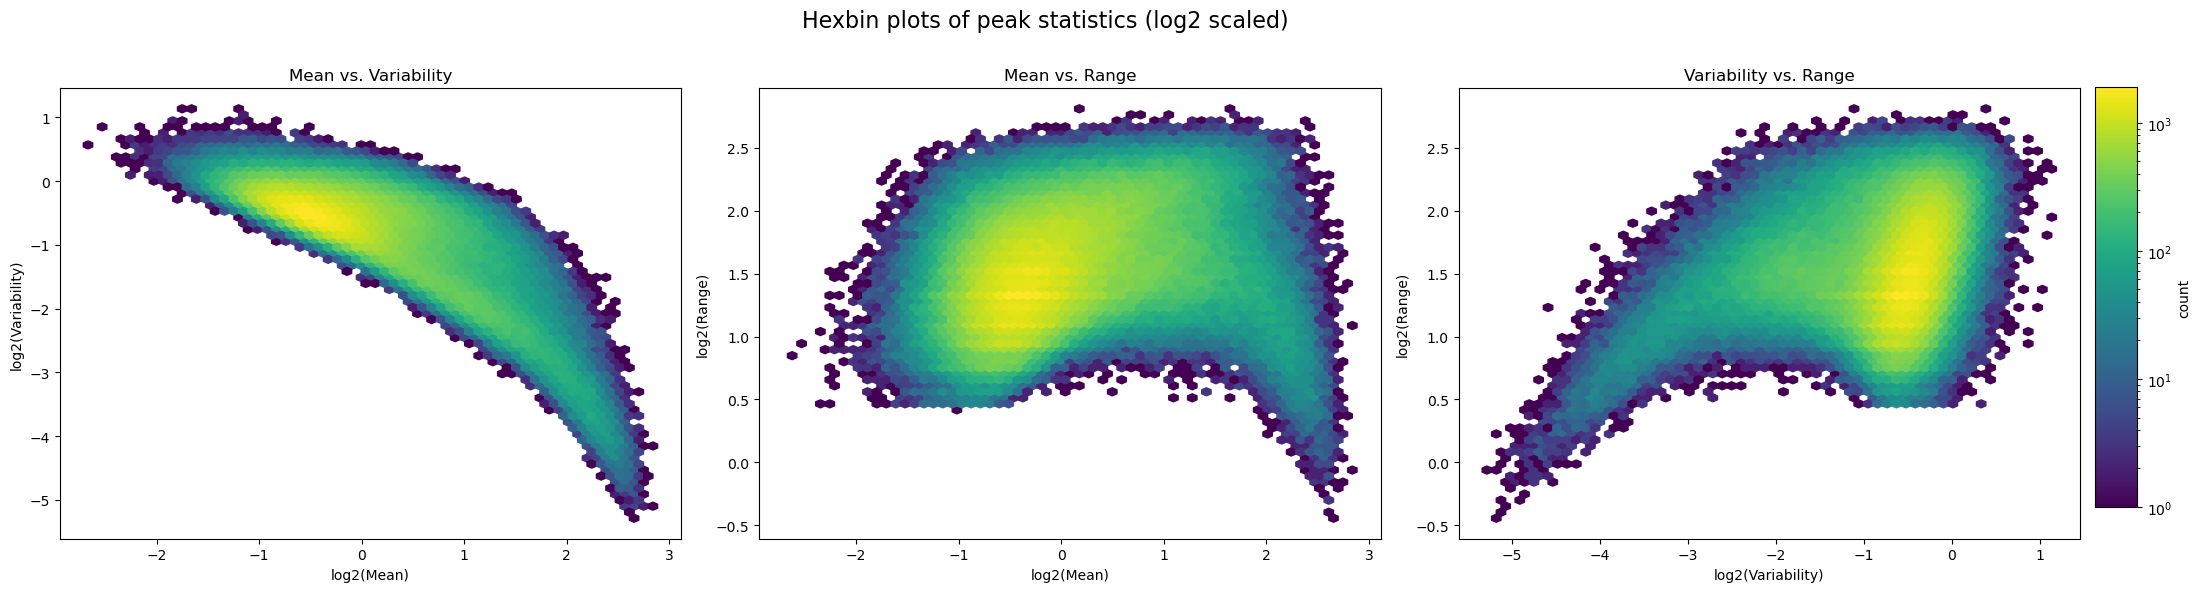

In [ ]:
ATAC_dis= ATAC_dis[ATAC_dis['_-log10_bestPvalue']>=1.3]

mean_log2 = np.log2(ATAC_dis['mean'] + 1e-3)
variability_log2 = np.log2(ATAC_dis['variability'] + 1e-3)
range_log2 = np.log2(ATAC_dis['range'] + 1e-3)

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

plots = [
    (mean_log2, variability_log2, "log2(Mean)", "log2(Variability)", "Mean vs. Variability"),
    (mean_log2, range_log2, "log2(Mean)", "log2(Range)", "Mean vs. Range"),
    (variability_log2, range_log2, "log2(Variability)", "log2(Range)", "Variability vs. Range"),
]

for ax, (x, y, xlabel, ylabel, title) in zip(axes, plots):
    hb = ax.hexbin(x, y, gridsize=60, cmap='viridis', norm=LogNorm())
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

fig.suptitle("Hexbin plots of peak statistics (log2 scaled)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
fig.colorbar(hb, cax=cbar_ax, label='count')

plt.show()

#### 1.2 Should some peaks or cell types be removed due to technical issues (quality control) or lack of signal? Should we apply additional normalization or thresholds?
---

##### ATAC signal

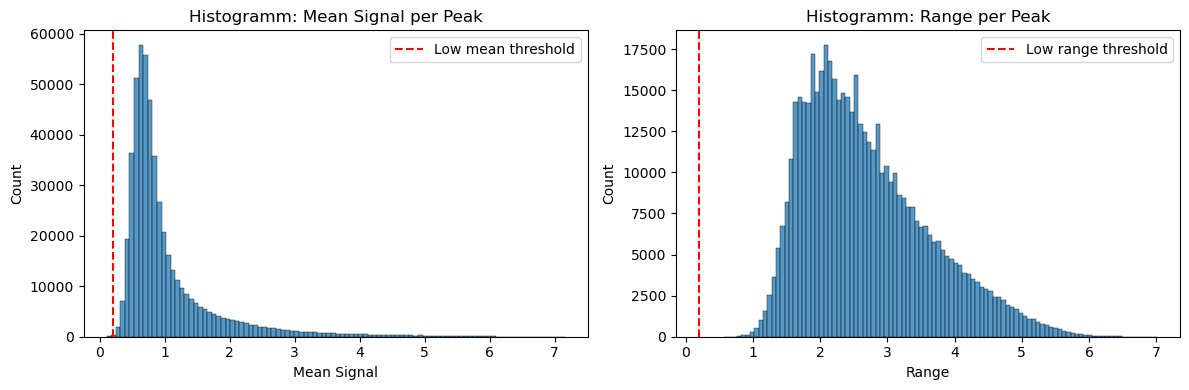

Peaks with low signal (mean < 0.2 und range < 0.2): 0 of 512590 peaks (0.00%)


In [ ]:
# mean and range per peak
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(ATAC_dis['mean'], bins=100)
plt.axvline(0.2, color='red', linestyle='--', label='Low mean threshold')
plt.title("Histogramm: Mean Signal per Peak")
plt.xlabel("Mean Signal")
plt.legend()

plt.subplot(1,2,2)
sns.histplot(ATAC_dis['range'], bins=100)
plt.axvline(0.2, color='red', linestyle='--', label='Low range threshold')
plt.title("Histogramm: Range per Peak")
plt.xlabel("Range")
plt.legend()
plt.tight_layout()
plt.show()

low_signal = ATAC_dis[(ATAC_dis['mean'] < 0.2) & (ATAC_dis['range'] < 0.2)]
n_low = len(low_signal)
total = len(ATAC_dis)
print(f"Peaks with low signal (mean < 0.2 and range < 0.2): {n_low} of {total} peaks ({n_low/total:.2%})")

No detectably low signal from ATAC-seq dataset.
Additional threshold for -log10pVal can be applied (e.g. >=1.3)

##### QC

Anzahl gemeinsamer Zelltypen: 89
Gemeinsame Zelltypen (Beispiel): ['LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM', 'proB.FrBC.BM', 'preB.FrD.BM', 'B.FrE.BM', 'B1b.PC']

Zelltypen nur in ATAC: ['FRC.SLN', 'Summit', 'mm10.60way.phastCons_scores', '_-log10_bestPvalue', 'Included.in.systematic.analysis']
Zelltypen nur in QC: ['FRC.CD140a+.Madcam-.CD35-.SLN']


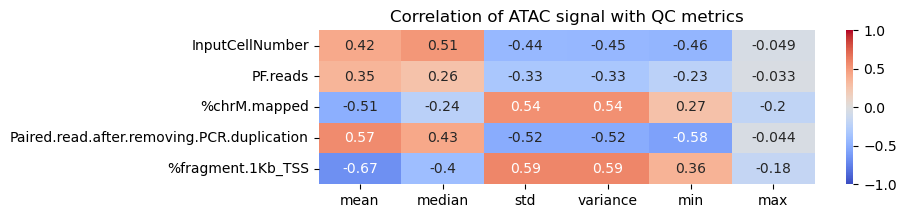

In [ ]:
atac_data=ATAC.copy()
  
atac_data=atac_data.select_dtypes(include='number')
atac_data=atac_data.T

atac_data.drop(['Summit', 'mm10.60way.phastCons_scores', '_-log10_bestPvalue', 'Included.in.systematic.analysis'], axis=0)

qc_data=QC.copy()

qc_data.set_index('CellType', inplace=True)

gemeinsame_zelltypen = list((atac_data.index).intersection(qc_data.index))

print(f"Anzahl gemeinsamer Zelltypen: {len(gemeinsame_zelltypen)}")
print("Gemeinsame Zelltypen (Beispiel):", list(gemeinsame_zelltypen)[:10])

print("\nZelltypen nur in ATAC:", list(set(atac_data.index) - set(qc_data.index))[:10])
print("Zelltypen nur in QC:", list(set(qc_data.index) - set(atac_data.index))[:10])

atac_stat_methods=['mean', 'median', 'std', 'variance', 'min', 'max']
qc_metric_col = ['InputCellNumber', 'PF.reads', '%chrM.mapped', 'Paired.read.after.removing.PCR.duplication', '%fragment.1Kb_TSS']

qc_data_numeric = qc_data.select_dtypes(include='number')
qc_data_grouped = qc_data_numeric.groupby(qc_data.index).mean()


def atac_stats_values(atac_data, gemeinsame_zelltypen, stat_type):
    if stat_type=='mean':
        atac_stat=atac_data.mean(axis=1)
    elif stat_type=='median':
        atac_stat=atac_data.median(axis=1)
    elif stat_type=='std':
        atac_stat=atac_data.std(axis=1)
    elif stat_type=='variance':
        atac_stat=atac_data.var(axis=1)
    elif stat_type=='variability':
        atac_stat=atac_data.std(axis=1)
    elif stat_type=='min':
        atac_stat=atac_data.min(axis=1)
    elif stat_type=='max':
        atac_stat=atac_data.max(axis=1)

    atac_vals = atac_stat.loc[gemeinsame_zelltypen]

    return atac_vals

first_run=True
idx=0

for stat_type in atac_stat_methods:
    atac_vals=atac_stats_values(atac_data, gemeinsame_zelltypen, stat_type)
    list_r=[]
    list_p=[]
    for qc_col in qc_metric_col:

        qc_vals = qc_data_grouped.loc[gemeinsame_zelltypen, qc_col]

        r, p_value=pearsonr(atac_vals, qc_vals)
        #print(f"Pearson r = {r:.3f}, p = {p_value:.3g}")

        list_r.append(r)
        list_p.append(p_value)

    if first_run:
        r_df=pd.DataFrame({stat_type: list_r}, index=qc_metric_col)
        first_run=False
    else:
        temp_df=pd.DataFrame({stat_type: list_r}, index=qc_metric_col)
        r_df=pd.concat([r_df, temp_df], axis=1)

plt.figure(figsize=(8, 2))
sns.heatmap(r_df, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation of ATAC signal with QC metrics')
plt.show()

##### mean, var, range vs. p-val threshold

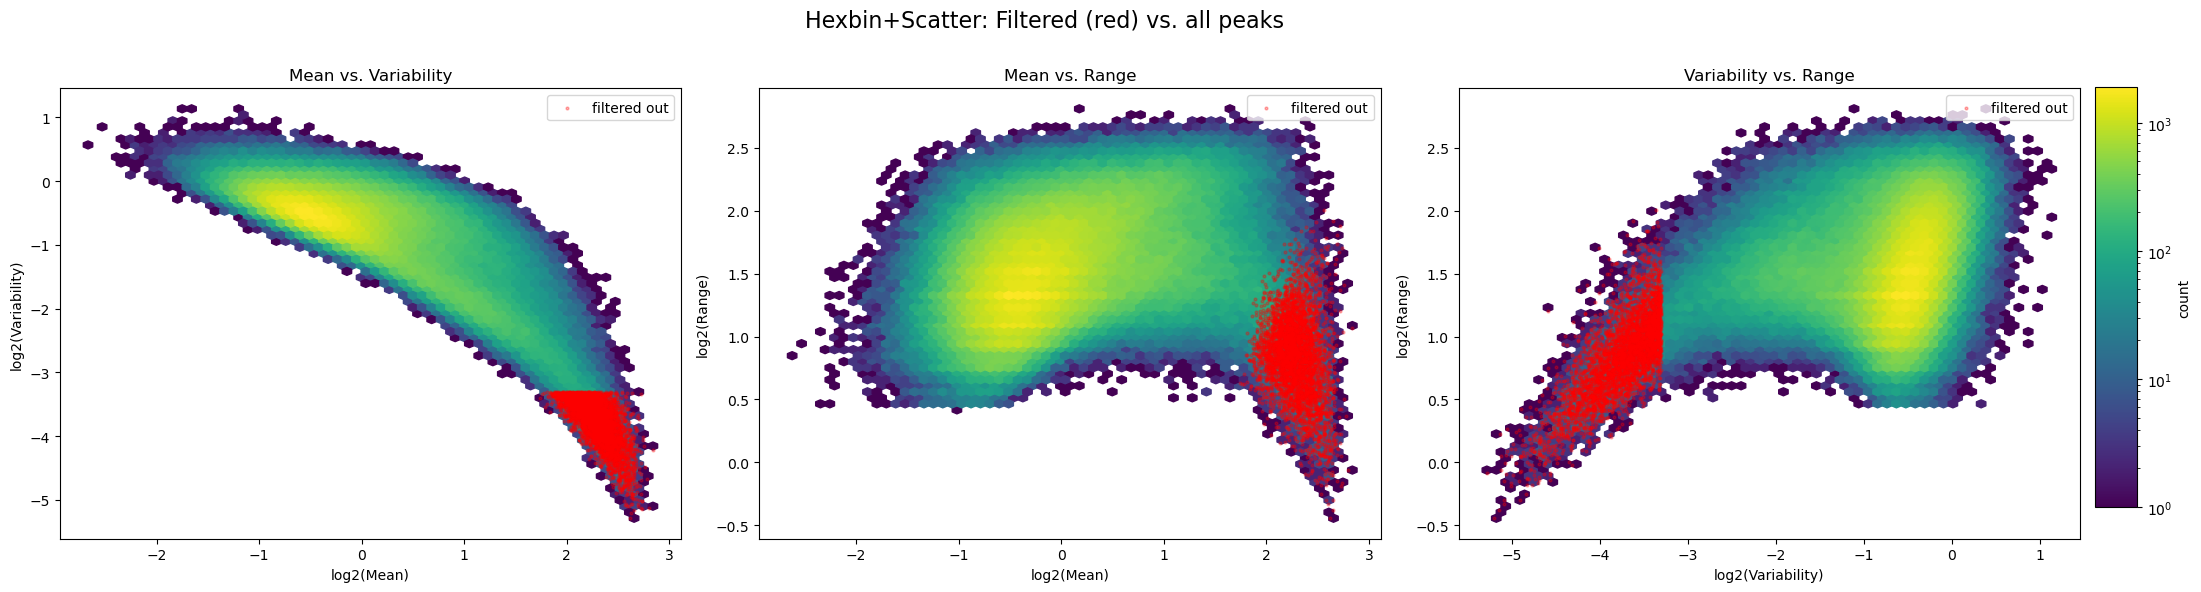

In [20]:
mean_thr = 0.05
var_thr = 0.1
range_thr = 0.1

# 2. Markiere Peaks, die zu filtern wären
ATAC_dis['low_mean'] = ATAC_dis['mean'] < mean_thr
ATAC_dis['low_variability'] = ATAC_dis['variability'] < var_thr
ATAC_dis['low_range'] = ATAC_dis['range'] < range_thr

# Filter-Maske: mind. eines der Kriterien erfüllt
filtered_mask = ATAC_dis['low_mean'] | ATAC_dis['low_variability'] | ATAC_dis['low_range']
filtered_mask_pval = ATAC_dis[ATAC_dis['_-log10_bestPvalue'] >= 1.3]

# 3. Berechne log2 für Statistiken
mean_log2 = np.log2(ATAC_dis['mean'] + 1e-3)
variability_log2 = np.log2(ATAC_dis['variability'] + 1e-3)
range_log2 = np.log2(ATAC_dis['range'] + 1e-3)

# 4. Plotte 3 Subplots (Hexbin+Scatter)
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

plots = [
    (mean_log2, variability_log2, "log2(Mean)", "log2(Variability)", "Mean vs. Variability"),
    (mean_log2, range_log2, "log2(Mean)", "log2(Range)", "Mean vs. Range"),
    (variability_log2, range_log2, "log2(Variability)", "log2(Range)", "Variability vs. Range"),
]

for ax, (x, y, xlabel, ylabel, title) in zip(axes, plots):
    # Hexbin für alle Peaks
    hb = ax.hexbin(x, y, gridsize=60, cmap='viridis', norm=LogNorm())
    # Scatter für gefilterte Peaks
    ax.scatter(
        x[filtered_mask], y[filtered_mask],
        color='red', s=4, alpha=0.3, label="filtered out"
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()

fig.suptitle("Hexbin+Scatter: Filtered (red) vs. all peaks", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
# Gemeinsame Colorbar für alle Subplots
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
fig.colorbar(hb, cax=cbar_ax, label='count')

plt.show()

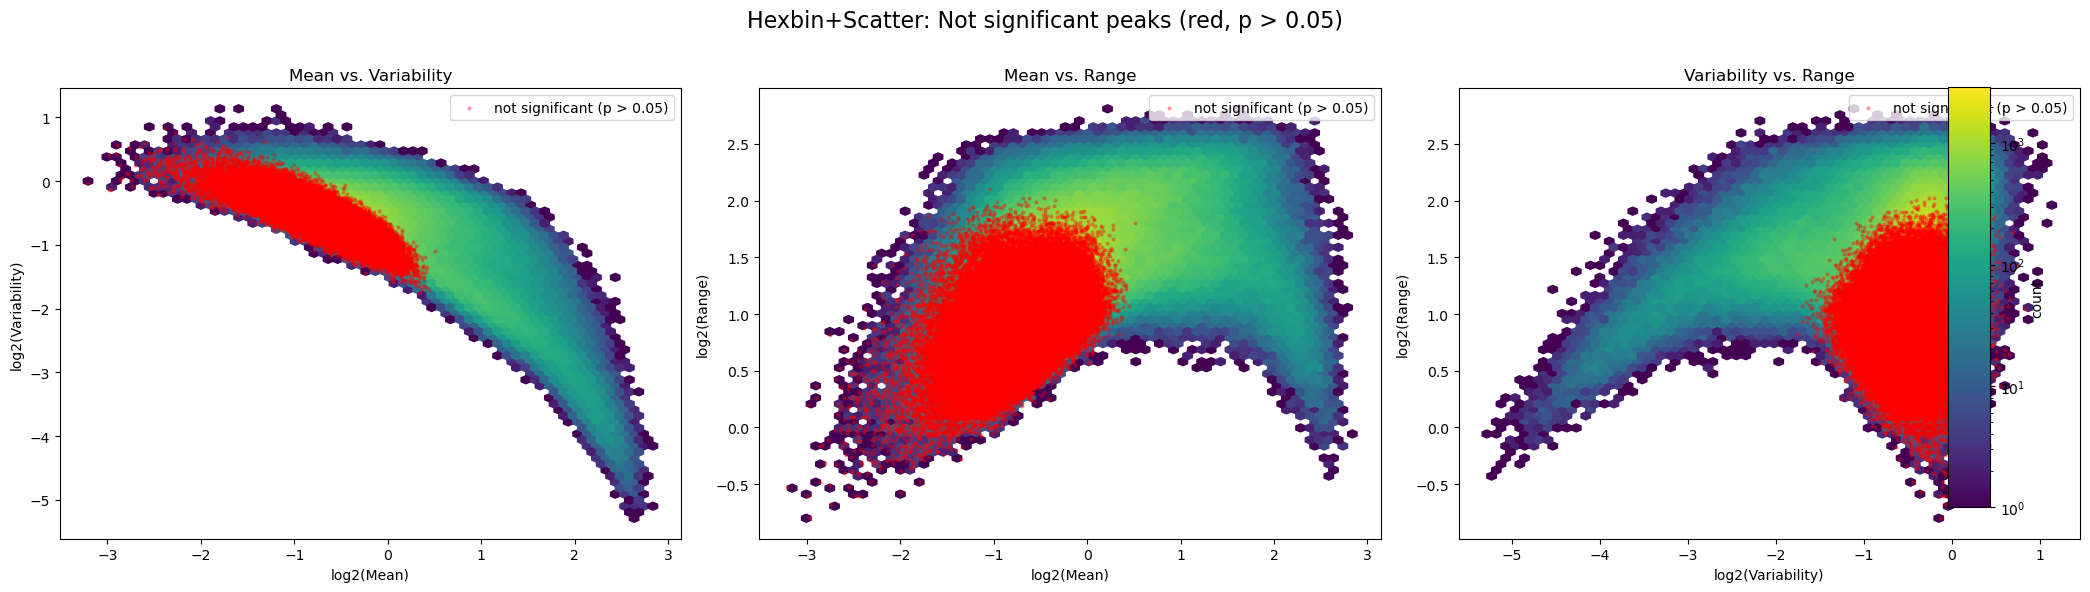

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

mean_thr = 0.05
var_thr = 0.1
range_thr = 0.1

# 2. Markiere Peaks, die zu filtern wären
ATAC_dis['low_mean'] = ATAC_dis['mean'] < mean_thr
ATAC_dis['low_variability'] = ATAC_dis['variability'] < var_thr
ATAC_dis['low_range'] = ATAC_dis['range'] < range_thr

# Filter-Maske: mind. eines der Kriterien erfüllt
filtered_mask = ATAC_dis['low_mean'] | ATAC_dis['low_variability'] | ATAC_dis['low_range']
filtered_mask_pval = ATAC_dis['_-log10_bestPvalue'] < 1.3

plots = [
    (mean_log2, variability_log2, "log2(Mean)", "log2(Variability)", "Mean vs. Variability"),
    (mean_log2, range_log2, "log2(Mean)", "log2(Range)", "Mean vs. Range"),
    (variability_log2, range_log2, "log2(Variability)", "log2(Range)", "Variability vs. Range"),
]

for ax, (x, y, xlabel, ylabel, title) in zip(axes, plots):
    hb = ax.hexbin(x, y, gridsize=60, cmap='viridis', norm=LogNorm())
    # Scatter nur für nicht-signifikante Peaks (p > 0.05)
    ax.scatter(
        x[filtered_mask_pval], y[filtered_mask_pval],
        color='red', s=4, alpha=0.3, label="not significant (p > 0.05)"
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()

fig.suptitle("Hexbin+Scatter: Not significant peaks (red, p > 0.05)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(hb, cax=cbar_ax, label='count')

plt.show()

## 2. Identification and classification of CREs
---

##### 2.1 How do we define CREs such as Promoter/Enhancer and other descriptive categories?

In [ ]:
# ATAC w/ additional data

from scipy.spatial import cKDTree
exons['TSS'] = np.where(exons['Strand'] == '+',
                        exons['Transcription Start'],
                        exons['Transcription End'])
distance_list = []
gene_list = []

for chrom in ATAC['chrom'].unique():
    #print(f"Verarbeite Chromosom: {chrom}")

    # Peaks auf diesem Chrom
    peaks_chr = ATAC[ATAC['chrom'] == chrom]
    peaks_pos = peaks_chr['Summit'].values

    # TSS-Koordinaten und Gen-Namen auf diesem Chrom
    exons_chr = exons[exons['Chromosom'] == chrom]
    tss_pos = exons_chr['TSS'].values
    gene_names = exons_chr['Genname'].values

    if len(tss_pos) > 0:
        # KDTree
        tree = cKDTree(tss_pos.reshape(-1, 1))
        dist, idx = tree.query(peaks_pos.reshape(-1, 1), k=1)
        nearest_tss = tss_pos[idx]
        signed_dist = peaks_pos - nearest_tss
        distance_list.extend(signed_dist)
        gene_list.extend(gene_names[idx])
    else:
        distance_list.extend([np.nan] * len(peaks_pos))
        gene_list.extend([np.nan] * len(peaks_pos))

# bins
bins = [0, 300, 1000, 5000, 20000, 1e6]
labels = ["0-300", "300-1k", "1k-5k", "5k-20k", ">20k"]

# gene context: up/downstrem or intergenic
def assign_peak_location(row, exons):
    chrom = row['chrom']
    peak_pos = row['Summit']
    # Alle Gene auf diesem Chrom
    exons_chr = exons[exons['Chromosom'] == chrom]
    # Finde alle Gene, für die der Peak im Bereich liegt
    hits = exons_chr[(exons_chr['Transcription Start'] <= peak_pos) & (exons_chr['Transcription End'] >= peak_pos)]
    if not hits.empty:
        return 'genic'
    else:
        # Bestimme nächstgelegenes Gen
        if len(exons_chr) > 0:
            # Hier nehmen wir den TSS des nächsten Gens
            distances = abs(exons_chr['TSS'] - peak_pos)
            idx = distances.idxmin()
            tss = exons_chr.loc[idx, 'TSS']
            # Liegt Peak vor oder nach TSS?
            if peak_pos < tss:
                return 'upstream'
            else:
                return 'downstream'
        else:
            return 'intergenic'

ATAC_dis = ATAC.copy()
ATAC_dis['nearest_gene'] = gene_list
ATAC_dis['distance_to_TSS'] = distance_list
ATAC_dis['mean'] = ATAC_scores.mean(axis=1, numeric_only=True)
ATAC_dis['median'] = ATAC_scores.median(axis=1, numeric_only=True)
ATAC_dis['var'] = ATAC_scores.var(axis=1, numeric_only=True)
ATAC_dis['sd'] = ATAC_scores.std(axis=1, numeric_only=True)
ATAC_dis['variability'] = ATAC_dis['sd'] / (ATAC_dis['mean'] + 1e-6)
ATAC_dis['min'] = ATAC_scores.min(axis=1)
ATAC_dis['max'] = ATAC_scores.max(axis=1)
ATAC_dis['range'] = ATAC_dis['max'] - ATAC_dis['min']
ATAC_dis['skewness'] = ATAC_scores.apply(scipy.stats.skew, axis=1)
ATAC_dis['region_type'] = np.where(ATAC_dis['distance_to_TSS'].abs() < 300, 'Promoter', 'Enhancer')
ATAC_dis['TSS_bin'] = pd.cut(ATAC_dis['distance_to_TSS'].abs(), bins=bins, labels=labels, include_lowest=True)
ATAC_dis['TSS_bin'] = ATAC_dis['TSS_bin'].astype(object)
ATAC_dis.loc[ATAC_dis['distance_to_TSS'].isna(), 'TSS_bin'] = 'no_TSS_found'
ATAC_dis['gene_context'] = ATAC_dis.apply(lambda row: assign_peak_location(row, exons), axis=1)
ATAC_dis['distal_enhancer_status'] = np.where(
    ATAC_dis['distance_to_TSS'].isna(),
    'no_TSS_found',
    np.where(ATAC_dis['distance_to_TSS'].abs() > 2000, 'distal_enhancer', 'proximal')
)

In [ ]:
#ATAC_scores = ATAC_dis.iloc[:,7:89]

#ATAC_dis = ATAC_dis[
    #(ATAC_dis['mean'] <= 5) &
    #(ATAC_dis['sd'] <= 2) &
    #(ATAC_dis['variability'] <= 2) &
    #(ATAC_dis['distance_to_TSS'].abs() <= 300)
#]

A2.1: over 300b distance to TSS: Enhancer.

##### 2.2 Does the signal vary significantly between Promoter and Enhancer?

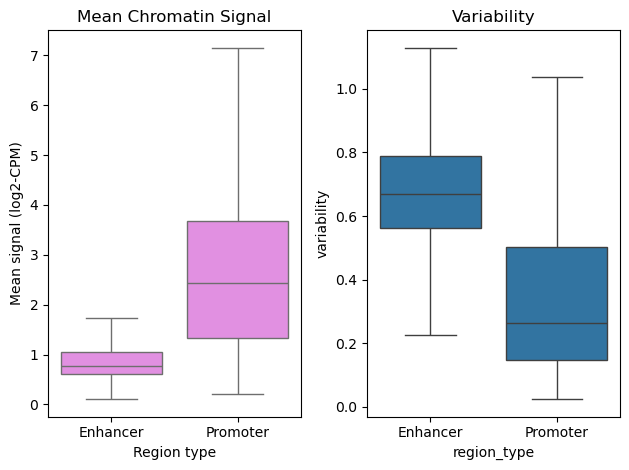

T-test promoter vs enhancer mean: t=192.57, p=0.0e+00
p < 1e-300 (close to 0, highly significant)
T-test promoter vs enhancer variability: t=-236.74, p=0.0e+00
p < 1e-300 (close to 0, highly significant)


In [23]:
plt.subplot(1,2,1)
sns.boxplot(x='region_type', y='mean', data=ATAC_dis, color='violet', showfliers=False)
plt.title("Mean Chromatin Signal")
plt.xlabel("Region type")
plt.ylabel("Mean signal (log2-CPM)")

plt.subplot(1,2,2)
sns.boxplot(x='region_type', y='variability', data=ATAC_dis, showfliers=False)
plt.title("Variability")

plt.tight_layout()
plt.show()

# mean-testing
prom = ATAC_dis[ATAC_dis['region_type']=='Promoter']['mean']
enh = ATAC_dis[ATAC_dis['region_type']=='Enhancer']['mean']
# t-Test
t_stat, p_val = scipy.stats.ttest_ind(prom, enh, equal_var=False)
print(f"T-test promoter vs enhancer mean: t={t_stat:.2f}, p={p_val:.1e}")
if p_val < 1e-300:
    print("p < 1e-300 (close to 0, highly significant)")

#variability testing
prom2 = ATAC_dis[ATAC_dis['region_type']=='Promoter']['variability']
enh2 = ATAC_dis[ATAC_dis['region_type']=='Enhancer']['variability']
# t-Test
t_stat, p_val = scipy.stats.ttest_ind(prom2, enh2, equal_var=False)
print(f"T-test promoter vs enhancer variability: t={t_stat:.2f}, p={p_val:.1e}")
if p_val < 1e-300:
    print("p < 1e-300 (close to 0, highly significant)")

If promoters are defined as everything with <300bp distance to a gene, a significant difference between enhancer/promoter can be seen in terms of mean peak signal and standard deviation.
Enhancers have a lower, more variable signal than promoters. To varify, we perform a t-test.

##### 2.3 Are CREs related to TSS distance and how are they located?

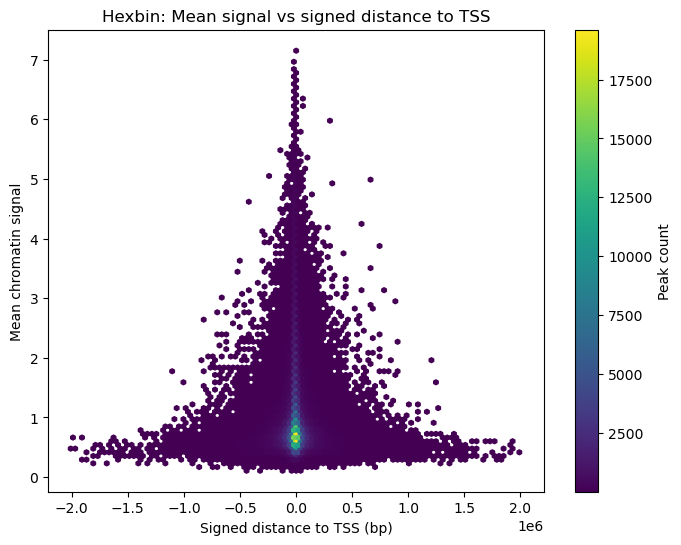

In [24]:
plt.figure(figsize=(8,6))
plt.hexbin(ATAC_dis['distance_to_TSS'], ATAC_dis['mean'], gridsize=100, cmap='viridis', mincnt=1)
plt.xlabel("Signed distance to TSS (bp)")
plt.ylabel("Mean chromatin signal")
plt.title("Hexbin: Mean signal vs signed distance to TSS")
plt.colorbar(label='Peak count')
plt.show()

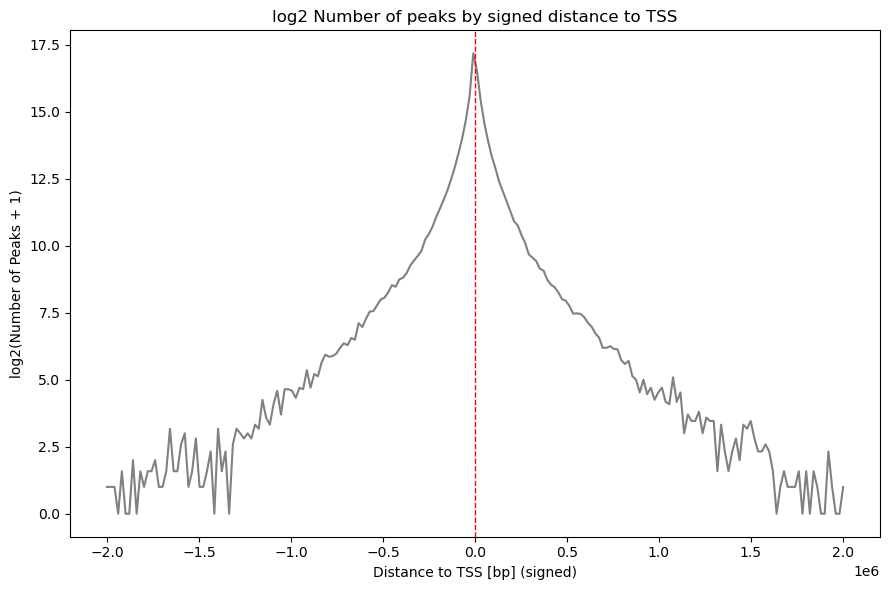

In [18]:
hist, bins = np.histogram(ATAC_dis['distance_to_TSS'].dropna(), bins=200)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(9,6))
plt.plot(bin_centers, np.log2(hist + 1), color='gray')  # +1 für log(0) avoidance
plt.axvline(0, color='red', linestyle='--', lw=1)
plt.xlabel('Distance to TSS [bp] (signed)')
plt.ylabel('log2(Number of Peaks + 1)')
plt.title('log2 Number of peaks by signed distance to TSS')
plt.tight_layout()
plt.show()

Open chromatin regions mostly lie at TSS/very close to TSS. 

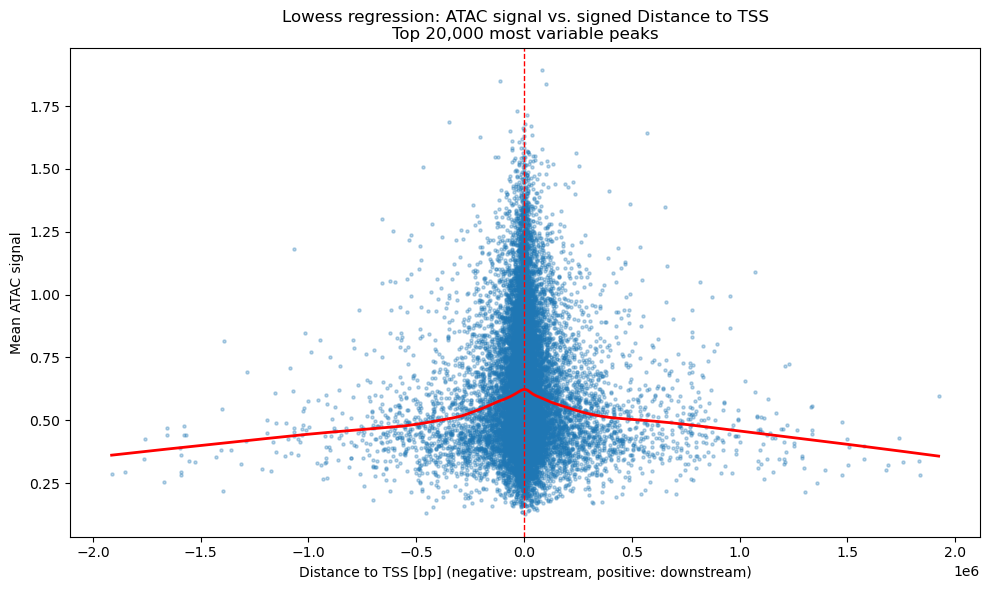

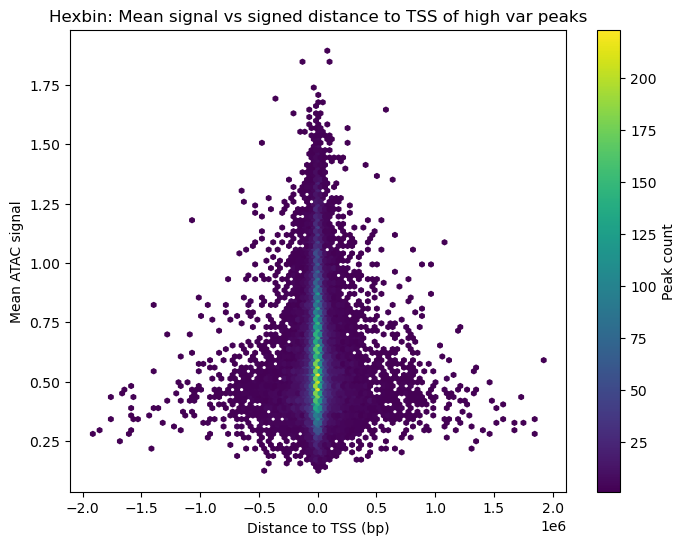

In [19]:
top_n = 20000
peaks_topvar = ATAC_dis.sort_values('variability', ascending=False).head(top_n)

# 2. Nur valide Werte (kein NaN, keine 0-Distanz)
mask_valid = peaks_topvar['distance_to_TSS'].notna() & (peaks_topvar['distance_to_TSS'] != 0)
x = peaks_topvar.loc[mask_valid, 'distance_to_TSS']
y = peaks_topvar.loc[mask_valid, 'mean']

# 3. Plot: Scatter + Lowess-Regression
plt.figure(figsize=(10, 6))
sns.regplot(
    x=x, y=y,
    scatter_kws={'s':5, 'alpha':0.3},
    line_kws={'color':'red', 'lw':2},
    lowess=True
)
plt.xlabel('Distance to TSS [bp] (negative: upstream, positive: downstream)')
plt.ylabel('Mean ATAC signal')
plt.title('Lowess regression: ATAC signal vs. signed Distance to TSS\nTop 20,000 most variable peaks')
plt.axvline(0, color='red', linestyle='--', lw=1)
plt.tight_layout()
plt.show()

#hexplot 

plt.figure(figsize=(8,6))
plt.hexbin(
    x=x, y=y,
    gridsize=100, cmap='viridis', mincnt=1)
plt.xlabel("Distance to TSS (bp)")
plt.ylabel("Mean ATAC signal")
plt.title("Hexbin: Mean signal vs signed distance to TSS of high var peaks")
plt.colorbar(label='Peak count')
plt.show()


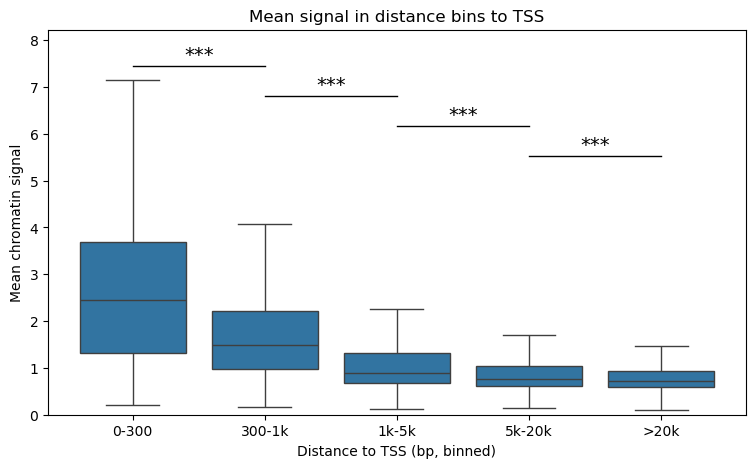

In [25]:
bins = [0, 300, 1000, 5000, 20000, 1e6]
labels = ["0-300", "300-1k", "1k-5k", "5k-20k", ">20k"]
grouped = [ATAC_dis[ATAC_dis['TSS_bin']==label]['mean'] for label in labels]
p_values = []
for i in range(len(labels)-1):
    stat, p = scipy.stats.ttest_ind(grouped[i], grouped[i+1], equal_var=False)
    p_values.append(p)

plt.figure(figsize=(9,5))
ax = sns.boxplot(x='TSS_bin', y='mean', data=ATAC_dis, showfliers=False, order=labels)
plt.title("Mean signal in distance bins to TSS")
plt.xlabel("Distance to TSS (bp, binned)")
plt.ylabel("Mean chromatin signal")

# Berechnung für die Linien wie gehabt
y_max = ATAC_dis['mean'].max()
y_start = y_max + 0.3
y_offset = y_max * 0.09

for i, p in enumerate(p_values):
    x1, x2 = i, i+1
    y = y_start - i * y_offset
    marker = functions.significance_marker(p)
    plt.plot([x1, x2], [y, y], lw=1, c='k')
    plt.text((x1+x2)*.5, y + y_offset*0.05, marker, ha='center', va='bottom', color='k', fontsize=14)

# Skala anpassen
plt.ylim(0, y_start + y_offset * 1.2)
plt.show()

OCRs closer to TSS have higher ATAC signals compared to those further away (as in Promoter vs Enhancer Mean Signal)

In [ ]:
ATAC_dis = pd.read_csv("D:\\Uni\\4. Semester\\Bioinfo\\datasets\\ATAC_dis_annotated.csv", header=0, index_col=0)
# watch the path!

In [45]:
def correlate_promoter_atac_rna_all_cres(ATAC_dis, RNA, ATAC_scores):
    
    gemeinsame_celltypen = [col for col in ATAC_scores.columns if col in RNA.columns]
    print(f"Mutual Celltypes ({len(gemeinsame_celltypen)}):", gemeinsame_celltypen)

    promoter_peaks = ATAC_dis[ATAC_dis['distance_to_TSS'] <= 600000].copy()
    
    results = []

    for idx, row in promoter_peaks.iterrows():
        
        gene_list = str(row.get('genes.within.100Kb', '')).split(',')
        gene_list = [g.strip() for g in gene_list if g.strip() and g.strip() in RNA.index]

        for gene in gene_list:

            atac_vec = row[gemeinsame_celltypen].values.astype(float)
            rna_vec = RNA.loc[gene, gemeinsame_celltypen].values.astype(float)

            if not (np.isnan(atac_vec).any() or np.isnan(rna_vec).any()):
                r, p = scipy.stats.pearsonr(atac_vec, rna_vec)
                results.append({
                    'peak_id': idx,
                    'gene': gene,
                    'r': r,
                    'p': p,
                    'distance_to_TSS': row['distance_to_TSS'],
                    'region_type': row['region_type']
                })

    print(f"Anzahl berechnete Korrelationen: {len(results)}")
    return pd.DataFrame(results)

cor_df = correlate_promoter_atac_rna_all_cres(
    ATAC_dis[ATAC_dis.index.isin(ATAC_top)],
    RNA,
    ATAC_scores
)

Mutual Celltypes (85): ['LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM', 'proB.FrBC.BM', 'B.FrE.BM', 'B1b.PC', 'B.T1.Sp', 'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp', 'B.MZ.Sp', 'B.Fo.Sp', 'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp', 'B.PC.Sp', 'B.PC.BM', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.8.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'Treg.4.FP3+.Nrplo.Co', 'Treg.4.25hi.Sp', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'Tgd.g2+d17.24a+.Th', 'Tgd.g2+d17.LN', 'Tgd.g2+d1.24a+.Th', 'Tgd.g2+d1.LN', 'Tgd.g1.1+d1.24a+.Th', 'Tgd.g1.1+d1.LN', 'Tgd.Sp', 'NK.27+11b-.BM', 'NK.27+11b+.BM', 'NK.27-11b+.BM', 'NK.27+11b-.Sp', 'NK.27+11b+.Sp', 'NK.27-11b+.Sp', 'ILC2.SI', 'ILC3.NKp46-CCR6-.SI', 'ILC3.NKp46+.SI', 'ILC3.CCR6+.SI', '

Mutual Celltypes (85): ['LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM', 'proB.FrBC.BM', 'B.FrE.BM', 'B1b.PC', 'B.T1.Sp', 'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp', 'B.MZ.Sp', 'B.Fo.Sp', 'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp', 'B.PC.Sp', 'B.PC.BM', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.8.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'Treg.4.FP3+.Nrplo.Co', 'Treg.4.25hi.Sp', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'Tgd.g2+d17.24a+.Th', 'Tgd.g2+d17.LN', 'Tgd.g2+d1.24a+.Th', 'Tgd.g2+d1.LN', 'Tgd.g1.1+d1.24a+.Th', 'Tgd.g1.1+d1.LN', 'Tgd.Sp', 'NK.27+11b-.BM', 'NK.27+11b+.BM', 'NK.27-11b+.BM', 'NK.27+11b-.Sp', 'NK.27+11b+.Sp', 'NK.27-11b+.Sp', 'ILC2.SI', 'ILC3.NKp46-CCR6-.SI', 'ILC3.NKp46+.SI', 'ILC3.CCR6+.SI', '

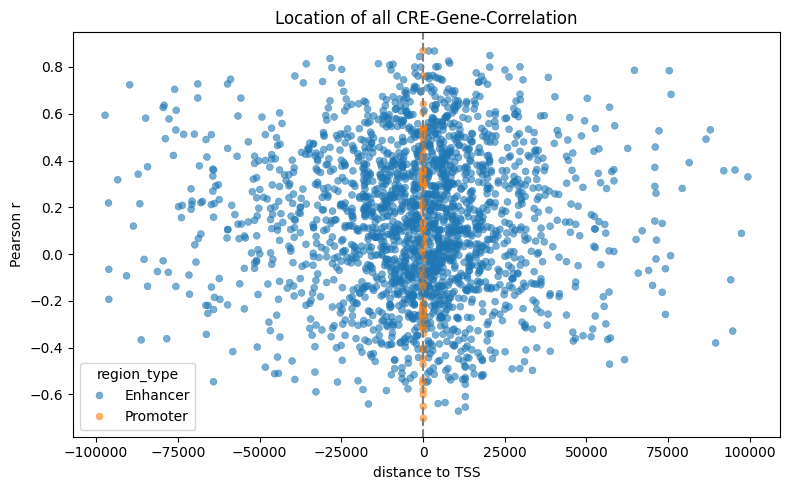

In [46]:
cor_df = correlate_promoter_atac_rna_all_cres(
    ATAC_dis[ATAC_dis.index.isin(ATAC_top)],
    RNA,
    ATAC_scores
)

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=cor_df, x='distance_to_TSS', y='r',
    hue='region_type', alpha=0.6, edgecolor=None, s=25
)
plt.axvline(0, color='gray', linestyle='--')
plt.title('Location of all CRE-Gene-Correlation')
plt.xlabel('distance to TSS')
plt.ylabel('Pearson r')
plt.tight_layout()
plt.show()

Mutual Celltypes (85): ['LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM', 'proB.FrBC.BM', 'B.FrE.BM', 'B1b.PC', 'B.T1.Sp', 'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp', 'B.MZ.Sp', 'B.Fo.Sp', 'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp', 'B.PC.Sp', 'B.PC.BM', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.8.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'Treg.4.FP3+.Nrplo.Co', 'Treg.4.25hi.Sp', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'Tgd.g2+d17.24a+.Th', 'Tgd.g2+d17.LN', 'Tgd.g2+d1.24a+.Th', 'Tgd.g2+d1.LN', 'Tgd.g1.1+d1.24a+.Th', 'Tgd.g1.1+d1.LN', 'Tgd.Sp', 'NK.27+11b-.BM', 'NK.27+11b+.BM', 'NK.27-11b+.BM', 'NK.27+11b-.Sp', 'NK.27+11b+.Sp', 'NK.27-11b+.Sp', 'ILC2.SI', 'ILC3.NKp46-CCR6-.SI', 'ILC3.NKp46+.SI', 'ILC3.CCR6+.SI', '

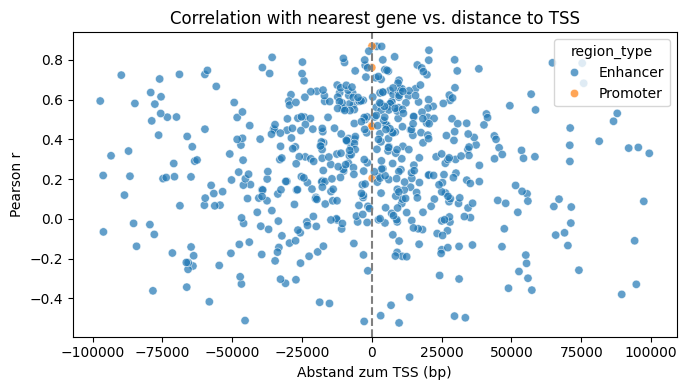

In [47]:
nearest_gene_df = ATAC_dis[['nearest_gene']].copy()
nearest_gene_df['peak_id'] = nearest_gene_df.index  # Damit wir später mergen können

cor_df = correlate_promoter_atac_rna_all_cres(
    ATAC_dis[ATAC_dis.index.isin(ATAC_top)],
    RNA,
    ATAC_scores
)

# Filter: Nur Korrelationen mit dem nearest gene behalten
cor_df_nearest = cor_df.merge(
    nearest_gene_df,
    left_on=['peak_id', 'gene'],
    right_on=['peak_id', 'nearest_gene']
)

# Plot
plt.figure(figsize=(7,4))
sns.scatterplot(data=cor_df_nearest, x='distance_to_TSS', y='r', hue='region_type', alpha=0.7)
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel('Abstand zum TSS (bp)')
plt.ylabel('Pearson r')
plt.title('Correlation with nearest gene vs. distance to TSS')
plt.tight_layout()
plt.show()

##### 2.4 How are CREs associated with genes? 

In [4]:
cor_df = functions.correlate_promoter_atac_rna(ATAC_dis[ATAC_dis.index.isin(ATAC_top)], RNA, ATAC_scores)
print(cor_df.columns)

print("Promoter peaks:", ATAC_dis[ATAC_dis['region_type'] == 'Promoter'].shape)
promoter_peaks = ATAC_dis[ATAC_dis['region_type'] == 'Promoter'].copy()
genes_in_promoters = set(promoter_peaks['nearest_gene'])
genes_in_rna = set(RNA.index)
gemeinsame_genes = genes_in_promoters & genes_in_rna
print(f"Genes in promoter peaks: {len(genes_in_promoters)}")
print(f"Genes in RNA index: {len(genes_in_rna)}")
print(f"mutual genes: {len(gemeinsame_genes)}")
print(cor_df['r'].isna().sum(), "NaNs in col 'r'")
print(cor_df.shape[0], "vals in 'r'")

same cell types (85):
Number of calculated correlations: 326
Index(['peak_id', 'gene', 'r', 'p'], dtype='object')
Promoter peaks: (28047, 112)
Genes in promoter peaks: 17069
Genes in RNA index: 6451
mutual genes: 5751
0 NaNs in col 'r'
326 vals in 'r'


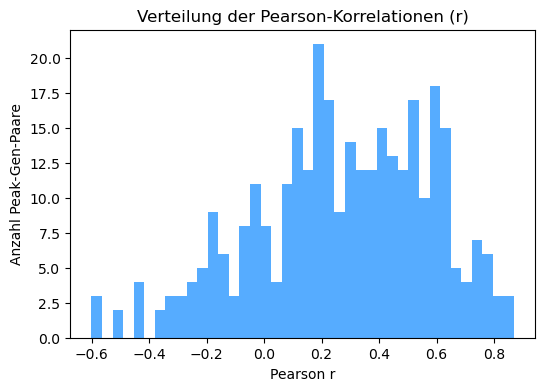

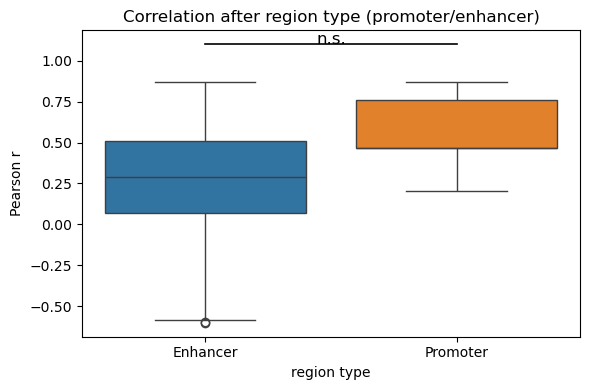

t-Test p=7.01e-02
Mann-Whitney p=4.54e-02
both test >0.05


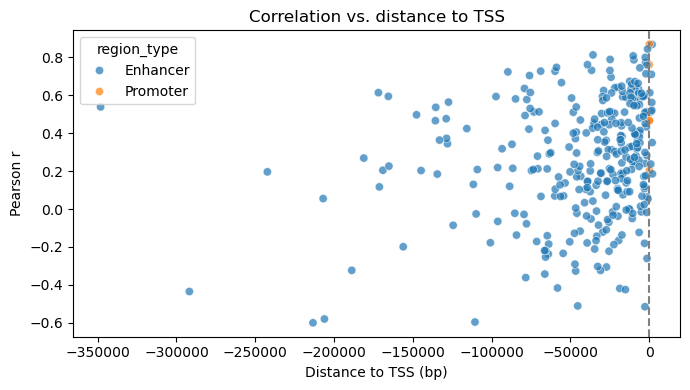

Number of peaks downstream (> 0 ): 12
Number of peaks upstream (<0): 314


In [7]:
cor_df['region_type'] = ATAC_dis.loc[cor_df['peak_id'], 'region_type'].values
cor_df['distance_to_TSS'] = ATAC_dis.loc[cor_df['peak_id'], 'distance_to_TSS'].values
#cor_df['region_type'] = np.where(cor_df['distance_to_TSS'].abs() <= 2000, 'near_TSS', 'DE')

# histogram
plt.figure(figsize=(6,4))
plt.hist(cor_df['r'], bins=40, color='dodgerblue', alpha=0.75)
plt.xlabel('Pearson r')
plt.ylabel('Anzahl Peak-Gen-Paare')
plt.title('Verteilung der Pearson-Korrelationen (r)')
plt.show()

promoter_r = cor_df[cor_df['region_type'] == 'Promoter']['r']
enhancer_r = cor_df[cor_df['region_type'] == 'Enhancer']['r']

# t-Test
t_stat, t_pval = scipy.stats.ttest_ind(promoter_r, enhancer_r, equal_var=False)
# Mann-Whitney-U-Test
u_stat, u_pval = scipy.stats.mannwhitneyu(promoter_r, enhancer_r, alternative='two-sided')

# boxplot after ±2kB or Enhancer
plt.figure(figsize=(6,4))
sns.boxplot(data=cor_df, x='region_type', hue='region_type', y='r', legend=False)
plt.xlabel('region type')
plt.ylabel('Pearson r')
plt.title('Correlation after region type (promoter/enhancer)')
star = functions.significance_marker(t_pval)

# coordinates
plt.plot([0, 1], [1.1, 1.1], c='k', lw=1.2)
plt.text(0.5, 1.1, star, ha='center', fontsize=12)

#plt.ylim(0, y_start + y_offset * 1.2)
plt.tight_layout()
plt.show()


print(f"t-Test p={t_pval:.2e}\nMann-Whitney p={u_pval:.2e}\nboth test >0.05")

plt.figure(figsize=(7,4))
sns.scatterplot(data=cor_df, x='distance_to_TSS', y='r', hue='region_type', alpha=0.7)
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel('Distance to TSS (bp)')
plt.ylabel('Pearson r')
plt.title('Correlation vs. distance to TSS')
plt.tight_layout()
plt.show()

print("Number of peaks downstream (>", 0, "):", (cor_df['distance_to_TSS'] > 0).sum())
print("Number of peaks upstream (<0):", (cor_df['distance_to_TSS'] < 0).sum())

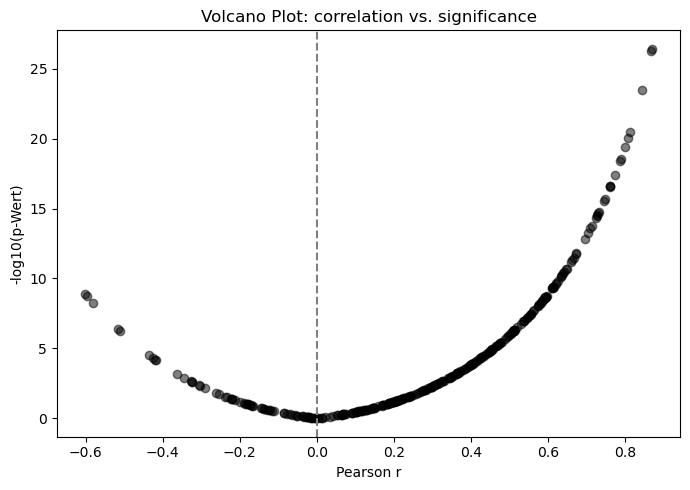

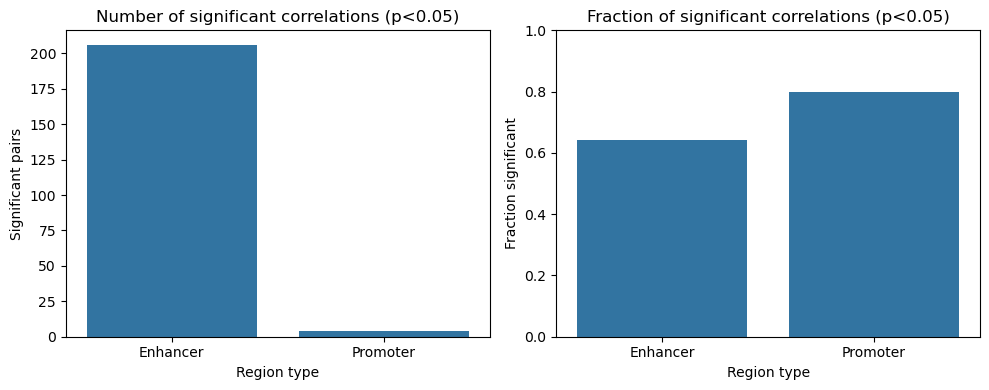

Top 10 positive correlations:
                        peak_id     gene         r             p region_type
189  ImmGenATAC1219.peak_298433    Lime1  0.869547  3.703474e-27    Promoter
153  ImmGenATAC1219.peak_245050    Syvn1  0.868470  5.092539e-27    Enhancer
245  ImmGenATAC1219.peak_380839    Erp29  0.844458  3.219305e-24    Enhancer
210  ImmGenATAC1219.peak_339663  Dennd4c  0.813351  3.182940e-21    Enhancer
224  ImmGenATAC1219.peak_355863      Pgd  0.808162  8.872271e-21    Enhancer
187  ImmGenATAC1219.peak_296988     Ctsz  0.800026  4.165294e-20    Enhancer
21    ImmGenATAC1219.peak_49303     Psap  0.789469  2.795036e-19    Enhancer
125  ImmGenATAC1219.peak_211046    Srpk1  0.787389  4.015309e-19    Enhancer
86   ImmGenATAC1219.peak_148518    Prkcd  0.773327  4.199618e-18    Enhancer
150  ImmGenATAC1219.peak_243450    Cndp2  0.761927  2.497455e-17    Promoter

Top 10 negative correlations:
                        peak_id      gene         r             p region_type
64   ImmGenATA

In [9]:
plt.figure(figsize=(7,5))
plt.scatter(cor_df['r'], -np.log10(cor_df['p']), c='k', alpha=0.5)
plt.xlabel('Pearson r')
plt.ylabel('-log10(p-Wert)')
plt.title('Volcano Plot: correlation vs. significance')
plt.axvline(0, color='grey', linestyle='--')
plt.tight_layout()
plt.show()

signif = cor_df[cor_df['p'] < 0.05]
total_per_region = cor_df['region_type'].value_counts()
signif_per_region = signif['region_type'].value_counts()
fraction_signif = signif_per_region / total_per_region
fraction_signif_df = fraction_signif.reset_index()
fraction_signif_df.columns = ['region_type', 'fraction_significant']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(data=signif, x='region_type', ax=axes[0])
axes[0].set_title('Number of significant correlations (p<0.05)')
axes[0].set_ylabel('Significant pairs')
axes[0].set_xlabel('Region type')

sns.barplot(data=fraction_signif_df, x='region_type', y='fraction_significant', ax=axes[1])
axes[1].set_title('Fraction of significant correlations (p<0.05)')
axes[1].set_ylabel('Fraction significant')
axes[1].set_xlabel('Region type')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("Top 10 positive correlations:")
print(cor_df.nlargest(10, 'r')[['peak_id', 'gene', 'r', 'p', 'region_type']])
print("\nTop 10 negative correlations:")
print(cor_df.nsmallest(10, 'r')[['peak_id', 'gene', 'r', 'p', 'region_type']])
print("\nTop 10 significant correlations:")
print(cor_df.nsmallest(10, 'p')[['peak_id', 'gene', 'r', 'p', 'region_type']])

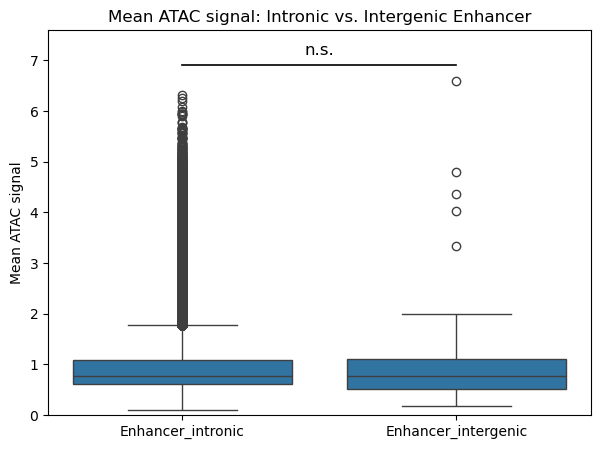

t-test: p = 2.580e-01


In [10]:
def annotate_enhancer(row):
    if row['region_type'] == 'Promoter':
        return 'Promoter'
    elif row['region_type'] == 'Enhancer' and row['gene_context'] == 'genic':
        return 'Enhancer_intronic'
    elif row['region_type'] == 'Enhancer' and row['gene_context'] == 'intergenic':
        return 'Enhancer_intergenic'
    else:
        return 'Other'

ATAC_dis['enhancer_type'] = ATAC_dis.apply(annotate_enhancer, axis=1)

enhancers = ATAC_dis[ATAC_dis['enhancer_type'].isin(['Enhancer_intronic', 'Enhancer_intergenic'])]

plt.figure(figsize=(7,5))
sns.boxplot(x='enhancer_type', y='mean', data=enhancers)
plt.title('Mean ATAC signal: Intronic vs. Intergenic Enhancer')
plt.xlabel('')
plt.ylabel('Mean ATAC signal')

# t-Test
intronic = enhancers[enhancers['enhancer_type'] == 'Enhancer_intronic']['mean']
intergenic = enhancers[enhancers['enhancer_type'] == 'Enhancer_intergenic']['mean']
stat, pval = scipy.stats.ttest_ind(intronic, intergenic, nan_policy='omit')

# significance
star = functions.significance_marker(pval)
# coordinates
y_max = enhancers['mean'].max()
y_start = y_max + 0.3
y_offset = y_max * 0.09
plt.plot([0, 1], [y_max*1.05, y_max*1.05], c='k', lw=1.2)
plt.text(0.5, y_max*1.08, star, ha='center', fontsize=12)

plt.ylim(0, y_start + y_offset * 1.2)
plt.show()
print(f't-test: p = {pval:.3e}')

Mutual Celltypes (85): ['LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM', 'proB.FrBC.BM', 'B.FrE.BM', 'B1b.PC', 'B.T1.Sp', 'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp', 'B.MZ.Sp', 'B.Fo.Sp', 'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp', 'B.PC.Sp', 'B.PC.BM', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.8.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'Treg.4.FP3+.Nrplo.Co', 'Treg.4.25hi.Sp', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'Tgd.g2+d17.24a+.Th', 'Tgd.g2+d17.LN', 'Tgd.g2+d1.24a+.Th', 'Tgd.g2+d1.LN', 'Tgd.g1.1+d1.24a+.Th', 'Tgd.g1.1+d1.LN', 'Tgd.Sp', 'NK.27+11b-.BM', 'NK.27+11b+.BM', 'NK.27-11b+.BM', 'NK.27+11b-.Sp', 'NK.27+11b+.Sp', 'NK.27-11b+.Sp', 'ILC2.SI', 'ILC3.NKp46-CCR6-.SI', 'ILC3.NKp46+.SI', 'ILC3.CCR6+.SI', '

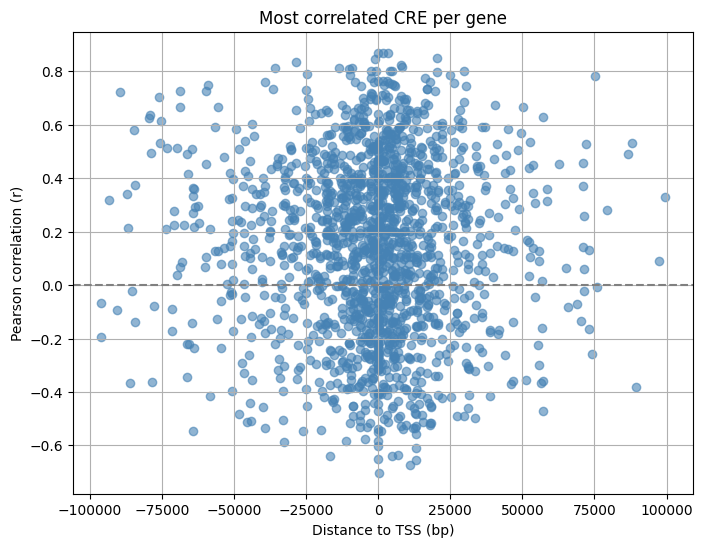

In [48]:
cor_df = correlate_promoter_atac_rna_all_cres(ATAC_dis[ATAC_dis.index.isin(ATAC_top)], RNA, ATAC_scores)

closest_peaks = cor_df.loc[cor_df.groupby('gene')['r'].apply(lambda x: x.abs().idxmax())]

# Plot: r vs distance_to_TSS
plt.figure(figsize=(8,6))
sc = plt.scatter(closest_peaks['distance_to_TSS'], closest_peaks['r'], c='steelblue', alpha=0.6)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Distance to TSS (bp)')
plt.ylabel('Pearson correlation (r)')
plt.title('Most correlated CRE per gene')
plt.grid(True)
plt.show()

Mutual Celltypes (85): ['LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM', 'proB.FrBC.BM', 'B.FrE.BM', 'B1b.PC', 'B.T1.Sp', 'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp', 'B.MZ.Sp', 'B.Fo.Sp', 'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp', 'B.PC.Sp', 'B.PC.BM', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.8.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'Treg.4.FP3+.Nrplo.Co', 'Treg.4.25hi.Sp', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'Tgd.g2+d17.24a+.Th', 'Tgd.g2+d17.LN', 'Tgd.g2+d1.24a+.Th', 'Tgd.g2+d1.LN', 'Tgd.g1.1+d1.24a+.Th', 'Tgd.g1.1+d1.LN', 'Tgd.Sp', 'NK.27+11b-.BM', 'NK.27+11b+.BM', 'NK.27-11b+.BM', 'NK.27+11b-.Sp', 'NK.27+11b+.Sp', 'NK.27-11b+.Sp', 'ILC2.SI', 'ILC3.NKp46-CCR6-.SI', 'ILC3.NKp46+.SI', 'ILC3.CCR6+.SI', '

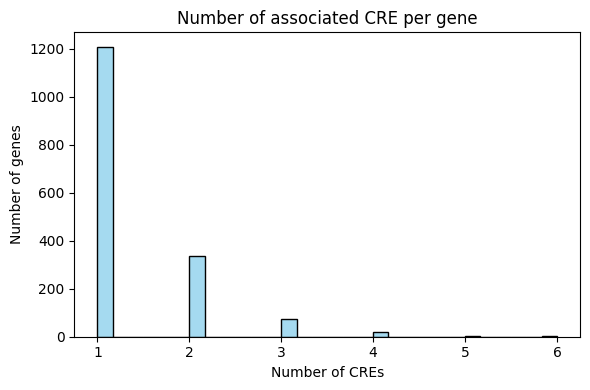

In [49]:
cor_df = correlate_promoter_atac_rna_all_cres(ATAC_dis[ATAC_dis.index.isin(ATAC_top)], RNA, ATAC_scores)

cre_per_gene = cor_df.groupby('gene')['peak_id'].nunique()

plt.figure(figsize=(6, 4))
sns.histplot(cre_per_gene, bins=30, kde=False, color='skyblue')
plt.xlabel('Number of CREs')
plt.ylabel('Number of genes')
plt.title('Number of associated CRE per gene')
plt.tight_layout()
plt.show()

##### 2.5 Are there multifunctional CREs or other irregularities?

In [11]:
ambiguous_peaks = ATAC_dis[(ATAC_dis['TSS_bin'] == '0-300') & (ATAC_dis['region_type'] == 'Enhancer')]
print(f"There are {len(ambiguous_peaks)} 'Enhancer' in the 0-300b TSS_distance bin.")

There are 61 'Enhancer' in the 0-300b TSS_distance bin.


Mutual Celltypes (85): ['LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM', 'proB.FrBC.BM', 'B.FrE.BM', 'B1b.PC', 'B.T1.Sp', 'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp', 'B.MZ.Sp', 'B.Fo.Sp', 'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp', 'B.PC.Sp', 'B.PC.BM', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.8.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'Treg.4.FP3+.Nrplo.Co', 'Treg.4.25hi.Sp', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'Tgd.g2+d17.24a+.Th', 'Tgd.g2+d17.LN', 'Tgd.g2+d1.24a+.Th', 'Tgd.g2+d1.LN', 'Tgd.g1.1+d1.24a+.Th', 'Tgd.g1.1+d1.LN', 'Tgd.Sp', 'NK.27+11b-.BM', 'NK.27+11b+.BM', 'NK.27-11b+.BM', 'NK.27+11b-.Sp', 'NK.27+11b+.Sp', 'NK.27-11b+.Sp', 'ILC2.SI', 'ILC3.NKp46-CCR6-.SI', 'ILC3.NKp46+.SI', 'ILC3.CCR6+.SI', '

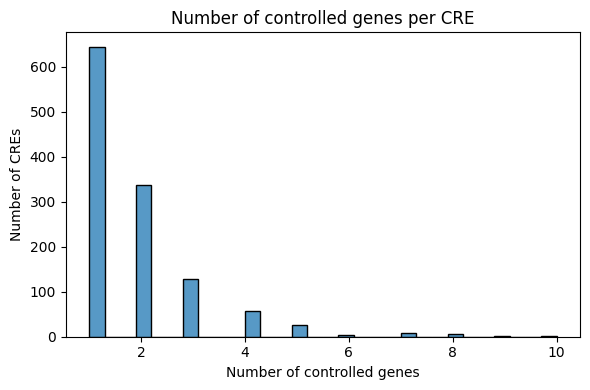

In [50]:
cor_df = correlate_promoter_atac_rna_all_cres(ATAC_dis[ATAC_dis.index.isin(ATAC_top)], RNA, ATAC_scores)

cre_counts = cor_df.groupby('peak_id')['gene'].nunique()

plt.figure(figsize=(6, 4))
sns.histplot(cre_counts, bins=30)
plt.title("Number of controlled genes per CRE")
plt.xlabel("Number of controlled genes")
plt.ylabel("Number of CREs")
plt.tight_layout()
plt.show()

##### 2.6 Which CREs control ab and gd T cell lineage specific genes?

##### 2.7 How do we characterize acivating and repressing CREs?

## 3. Identifcation of clusters of chromatin signal / gene expression and finding relations
---

##### 3.1 How do cell types cluster based on OCR and based on gene expression?

##### 3.1.1 Do they reproduce known relationship between cells and between OCR and gene expression?

##### 3.2 How do peaks (ATAC) cluster together?

##### 3.2.1 (How) do they differ from cell lineage specific clusters?

##### 3.3 Does the clustering change in respect to effect direciton on gene expression?

##### 3.4 Do CREs show specific properties within clusters?